In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# pull from database table with education data 

# engine = create_engine(AWS)

# employment_county_df = pd.read_sql('employ_county', engine)

In [3]:
employment_county_df  = pd.read_csv('../data_files/Employment_by_County_with_education_info.csv', index_col=0)
employment_county_df.head(5)

,geoid,county,labor_force,employed,unemployed,unemployed%_county,population,race_white,race_black,race_native,race_asian,race_islander,race_other,race_two_or_more,state,unemployement%_state,% completed_college_county,%not_completed_college_county,completed_college_county,Not_completed_college_county
index,,,,,,,,,,,,,,,,,,,,
0,1001,"Autauga County, Alabama",25838,24576,1262,4.9,58805,42160,11445,217,881,35,910,3157,Alabama,5.88,0.27,0.34,15625.41,19751.69
1,1003,"Baldwin County, Alabama",96763,91338,5425,5.6,231767,189399,18217,1582,2067,143,5335,15024,Alabama,5.88,0.32,0.28,73846.67,64105.86
2,1005,"Barbour County, Alabama",8587,7982,605,7.0,25223,11317,11933,116,117,1,1039,700,Alabama,5.88,0.12,0.36,2920.50,8980.53
3,1007,"Bibb County, Alabama",8640,8067,573,6.6,22293,16555,4413,60,32,9,465,759,Alabama,5.88,0.10,0.45,2313.68,10004.82
4,1009,"Blount County, Alabama",24661,23653,1008,4.1,59134,50663,845,337,178,24,3431,3656,Alabama,5.88,0.13,0.33,7742.66,19763.84


In [4]:
employment_county_df.isnull().values.any()

False

# Copy of the dataframe to feed ML 



In [5]:
employment_county_copy = employment_county_df.copy()

In [6]:
employment_county_copy.columns.to_list()

['geoid',
 'county',
 'labor_force',
 'employed',
 'unemployed',
 'unemployed%_county',
 'population',
 'race_white',
 'race_black',
 'race_native',
 'race_asian',
 'race_islander',
 'race_other',
 'race_two_or_more',
 'state',
 'unemployement%_state',
 '% completed_college_county',
 '%not_completed_college_county',
 'completed_college_county',
 'Not_completed_college_county']

In [7]:
employment_county_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3125 entries, 0 to 3124
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   geoid                          3125 non-null   int64  
 1   county                         3125 non-null   object 
 2   labor_force                    3125 non-null   int64  
 3   employed                       3125 non-null   int64  
 4   unemployed                     3125 non-null   int64  
 5   unemployed%_county             3125 non-null   float64
 6   population                     3125 non-null   int64  
 7   race_white                     3125 non-null   int64  
 8   race_black                     3125 non-null   int64  
 9   race_native                    3125 non-null   int64  
 10  race_asian                     3125 non-null   int64  
 11  race_islander                  3125 non-null   int64  
 12  race_other                     3125 non-null   i

In [8]:
# to increase model performance merging some of the race columns 
employment_county_copy['race_others']= employment_county_copy[['race_native','race_islander','race_other','race_two_or_more']].sum(axis=1)
employment_county_copy.head(5)

,geoid,county,labor_force,employed,unemployed,unemployed%_county,population,race_white,race_black,race_native,...,race_islander,race_other,race_two_or_more,state,unemployement%_state,% completed_college_county,%not_completed_college_county,completed_college_county,Not_completed_college_county,race_others
index,,,,,,,,,,,,,,,,,,,,,
0,1001,"Autauga County, Alabama",25838,24576,1262,4.9,58805,42160,11445,217,...,35,910,3157,Alabama,5.88,0.27,0.34,15625.41,19751.69,4319
1,1003,"Baldwin County, Alabama",96763,91338,5425,5.6,231767,189399,18217,1582,...,143,5335,15024,Alabama,5.88,0.32,0.28,73846.67,64105.86,22084
2,1005,"Barbour County, Alabama",8587,7982,605,7.0,25223,11317,11933,116,...,1,1039,700,Alabama,5.88,0.12,0.36,2920.50,8980.53,1856
3,1007,"Bibb County, Alabama",8640,8067,573,6.6,22293,16555,4413,60,...,9,465,759,Alabama,5.88,0.10,0.45,2313.68,10004.82,1293
4,1009,"Blount County, Alabama",24661,23653,1008,4.1,59134,50663,845,337,...,24,3431,3656,Alabama,5.88,0.13,0.33,7742.66,19763.84,7448


In [9]:
# reducing columns to improve model performance 
# employment_county_copy = employment_county_copy.drop(['race_native','race_islander','race_other','race_two_or_more'],axis=1)

In [10]:
employment_county_copy.isnull().values.any()

False

In [11]:
employment_county_copy.shape

(3125, 21)

In [12]:
employment_county_copy.columns.to_list()

['geoid',
 'county',
 'labor_force',
 'employed',
 'unemployed',
 'unemployed%_county',
 'population',
 'race_white',
 'race_black',
 'race_native',
 'race_asian',
 'race_islander',
 'race_other',
 'race_two_or_more',
 'state',
 'unemployement%_state',
 '% completed_college_county',
 '%not_completed_college_county',
 'completed_college_county',
 'Not_completed_college_county',
 'race_others']

In [13]:
employment_county_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3125 entries, 0 to 3124
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   geoid                          3125 non-null   int64  
 1   county                         3125 non-null   object 
 2   labor_force                    3125 non-null   int64  
 3   employed                       3125 non-null   int64  
 4   unemployed                     3125 non-null   int64  
 5   unemployed%_county             3125 non-null   float64
 6   population                     3125 non-null   int64  
 7   race_white                     3125 non-null   int64  
 8   race_black                     3125 non-null   int64  
 9   race_native                    3125 non-null   int64  
 10  race_asian                     3125 non-null   int64  
 11  race_islander                  3125 non-null   int64  
 12  race_other                     3125 non-null   i

In [14]:
employment_county_copy = employment_county_copy.drop(['county','state'],axis=1)

In [15]:
employment_county_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3125 entries, 0 to 3124
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   geoid                          3125 non-null   int64  
 1   labor_force                    3125 non-null   int64  
 2   employed                       3125 non-null   int64  
 3   unemployed                     3125 non-null   int64  
 4   unemployed%_county             3125 non-null   float64
 5   population                     3125 non-null   int64  
 6   race_white                     3125 non-null   int64  
 7   race_black                     3125 non-null   int64  
 8   race_native                    3125 non-null   int64  
 9   race_asian                     3125 non-null   int64  
 10  race_islander                  3125 non-null   int64  
 11  race_other                     3125 non-null   int64  
 12  race_two_or_more               3125 non-null   i

# Targeting "unemployed" but we can target any of the employment columns


In [43]:
# trying to drop some heavily weighing features to see how it affects model accuracy

# for true prediction our X should not have anything related to employment need so add education to the X 

X = employment_county_copy[['race_white', 'race_black', 'race_asian','race_others','completed_college_county','Not_completed_college_county']]

#X = employment_county_copy[['race_white', 'race_black', 'race_asian','race_others','completed_college_county','Not_completed_college_county','unemployement%_state','population','% completed_college_county','%not_completed_college_county']]

y = employment_county_copy['unemployed']


In [44]:
# option 1 = r2 0.96
# X = employment_county_copy[['race_white', 'race_black', 'race_asian','race_others','completed_college_county','Not_completed_college_county','unemployement%_state','population','% completed_college_county','%not_completed_college_county']]

# y = employment_county_copy['unemployed']


In [45]:
# option 2= 0.95
#X = employment_county_copy[['race_white', 'race_black', 'race_asian','race_others','completed_college_county','Not_completed_college_county']]
#y = employment_county_copy['unemployed']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=0)

In [47]:
regressor = RandomForestRegressor(n_estimators=10,random_state=0)
regressor.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [48]:
y_pred = regressor.predict(X_test)

In [49]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.9645956446429388

In [50]:
regressor.score(X_train,y_train)

0.9432804337182036

In [51]:
regressor.score(X_test,y_test)

0.9645956446429388

In [52]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mae

591.1302400000001

## Feature importance

In [39]:
sorted(zip(regressor.feature_importances_, X.columns), reverse=True)

[(0.5227849878552184, 'population'),
 (0.14331811471454556, 'Not_completed_college_county'),
 (0.09304145899640019, 'race_asian'),
 (0.088340938265724, 'race_white'),
 (0.07043280555144603, 'completed_college_county'),
 (0.06489599194383393, 'race_others'),
 (0.010732330321278643, 'race_black'),
 (0.0033755550739971384, 'unemployement%_state'),
 (0.0028499024312416397, '% completed_college_county'),
 (0.0002279148463145961, '%not_completed_college_county')]

### MAE consider the min max range

In [40]:
max_unemployed = employment_county_df['unemployed'].max()
min_unemployed = employment_county_df['unemployed'].min()
print ('min = ', min_unemployed)
print('max = ', max_unemployed)

min =  4
max =  629811


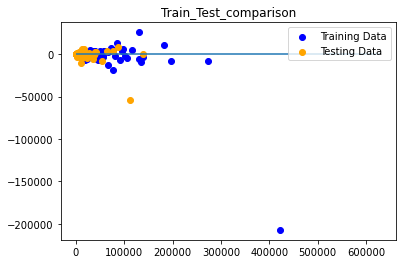

In [41]:
plt.scatter(regressor.predict(X_train), regressor.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(regressor.predict(X_test), regressor.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Train_Test_comparison")
plt.show()

In [42]:
print(f'Actual:\t\t{list(y_test[:10])}')
print(f'Predicted:\t{list(regressor.predict(X_test[:10]))}')

Actual:		[369, 129, 2149, 1436, 678, 1009, 1069, 11366, 186, 844]
Predicted:	[331.0, 145.9, 2119.8, 1435.4, 773.1, 1178.1, 1266.0, 8180.1, 368.9, 916.7]
